Firstly, I refer the kernel(https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08) to make this model,
so thanks a lot Sandeep Kumar!

In [1]:
import gc
import os
from pathlib import Path
import random
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error

# Loading data

In [2]:
#reduce the memory usage
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# using original data
root = Path('../input/ashrae-feather-format-for-fast-loading')

train_df = pd.read_feather(root/'train.feather')
# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df = pd.read_feather(root/'building_metadata.feather')
weather_df = pd.read_feather(root/'weather_train.feather')

In [4]:
DATA_PATH = "../input/ashrae-energy-prediction/"
train_df_csv = pd.read_csv(DATA_PATH + 'train.csv')

# Remove outliers
train_df_csv = train_df_csv[ train_df_csv['building_id'] != 1099 ]
train_df_csv = train_df_csv.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

building_df_csv = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_df_csv = pd.read_csv(DATA_PATH + 'weather_train.csv')

In [5]:
train_df['timestamp'] = train_df_csv['timestamp'].copy()
weather_df['timestamp'] = weather_df_csv['timestamp'].copy()
del weather_df_csv, train_df_csv
gc.collect()

34

# Feature engineering
- fill the null value and update some weather data

In [6]:
def fill_weather(weather_df):
    #find missing hours and add to weather dataframe
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]
    
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        missing_hour_data = pd.DataFrame(np.setdiff1d(hours_list, site_hours), columns=['timestamp'])
        missing_hour_data['site_id'] = site_id
        weather_df = pd.concat([weather_df, missing_hour_data])
    weather_df.reset_index(drop=True)
    
    #Add date time features
    weather_df['datetime'] = pd.to_datetime(weather_df['timestamp'])
    weather_df['day'] = weather_df['datetime'].dt.day
    weather_df['week'] = weather_df['datetime'].dt.week
    weather_df['month'] = weather_df['datetime'].dt.month
    
    # update values group by site_id, day, month
    weather_df = weather_df.set_index(['site_id', 'day', 'month'])
    
    for col in ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_direction', 'wind_speed',\
               'precip_depth_1_hr']:
        mean_filter = weather_df.groupby(['site_id', 'day', 'month'])[col].mean()
        mean_filter = pd.DataFrame(mean_filter.fillna(method='ffill'), columns=[col])
        
        weather_df.update(mean_filter, overwrite=False)
        
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime', 'day', 'week', 'month'], axis=1)
    
    return weather_df

- add and remove some features

In [7]:
def feature_engineering(df):
    df.sort_values('timestamp')
    df.reset_index(drop=True)
    
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    df['square_feet'] =  np.log1p(df['square_feet'])
    
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    le = LabelEncoder()
    df["primary_use"] = le.fit_transform(df["primary_use"])
    
    return df

In [8]:
#weather data filling
weather_df = fill_weather(weather_df)

#memeory reduce
train_df = reduce_mem_usage(train_df)
building_df = reduce_mem_usage(building_df)
weather_df = reduce_mem_usage(weather_df)

#mearge weather and building data into train data
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

train_df = feature_engineering(train_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


Memory usage of dataframe is 435.45 MB
Memory usage after optimization is: 322.23 MB
Decreased by 26.0%
Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.02 MB
Decreased by 24.1%
Memory usage of dataframe is 5.90 MB
Memory usage after optimization is: 2.66 MB
Decreased by 54.9%


# Training k-folds model

In [9]:
train_X = train_df.drop(['meter_reading'], axis=1)
train_y = np.log1p(train_df['meter_reading'])
del train_df
gc.collect()

0

In [10]:
categoricals = ['building_id', 'site_id', 'meter', 'primary_use', 'weekday']
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}
models = []
y_pred = np.zeros((train_y.shape[0],))
kf = KFold(n_splits=3)
for train_idx, valid_idx in kf.split(train_X):
    train_features, train_target = train_X.loc[train_idx], train_y.loc[train_idx]
    valid_features, valid_target = train_X.loc[valid_idx], train_y.loc[valid_idx]
    
    lgb_train = lgb.Dataset(train_features, label=train_target, categorical_feature=categoricals, free_raw_data=False)
    lgb_valid = lgb.Dataset(valid_features, label=valid_target, categorical_feature=categoricals, free_raw_data=False)
    
    model = lgb.train(params, train_set=lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_valid],\
                     verbose_eval=25, early_stopping_rounds=50)
    models.append(model)
    y_pred[valid_idx] = model.predict(valid_features, num_iteration=model.best_iteration).reshape(y_pred[valid_idx].shape)
    del train_features, train_target, valid_features, valid_target, lgb_train, lgb_valid
    gc.collect()
print("final score(rmse) : " + str(mean_squared_error(train_y, y_pred)))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.09612	valid_1's rmse: 1.2527
[50]	training's rmse: 0.898029	valid_1's rmse: 1.13238
[75]	training's rmse: 0.829808	valid_1's rmse: 1.11659
[100]	training's rmse: 0.79172	valid_1's rmse: 1.11707
[125]	training's rmse: 0.76465	valid_1's rmse: 1.12029
Early stopping, best iteration is:
[88]	training's rmse: 0.808621	valid_1's rmse: 1.11588
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.09623	valid_1's rmse: 1.21022
[50]	training's rmse: 0.907865	valid_1's rmse: 1.07489
[75]	training's rmse: 0.846485	valid_1's rmse: 1.04142
[100]	training's rmse: 0.814202	valid_1's rmse: 1.03391
[125]	training's rmse: 0.789423	valid_1's rmse: 1.03125
[150]	training's rmse: 0.771818	valid_1's rmse: 1.0317
Early stopping, best iteration is:
[119]	training's rmse: 0.795451	valid_1's rmse: 1.03072
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.06561	va

In [11]:
del train_X, train_y, y_pred
gc.collect()

0

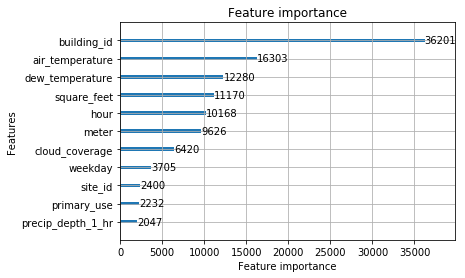

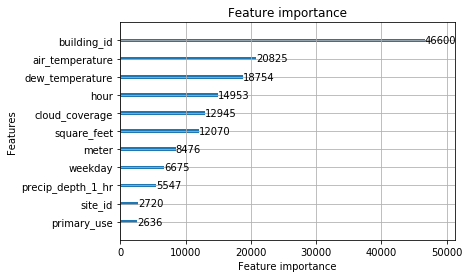

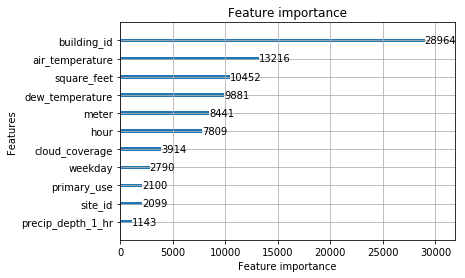

In [12]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

# Load and predict Test Data

In [13]:
#load test and weather data
test_df = pd.read_feather(root/'test.feather')
test_df_csv = pd.read_csv(DATA_PATH + 'test.csv')
test_df['timestamp'] = test_df_csv['timestamp'].copy()
row_ids = test_df['row_id']
test_df = test_df.drop('row_id', axis=1)
weather_df = pd.read_feather(root/'weather_test.feather')
weather_df_csv = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather_df['timestamp'] = weather_df_csv['timestamp'].copy()
weather_df = fill_weather(weather_df)
weather_df = reduce_mem_usage(weather_df)
test_df = reduce_mem_usage(test_df)

#merge
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df, building_df, weather_df_csv, test_df_csv
gc.collect()

test_df = feature_engineering(test_df)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


Memory usage of dataframe is 11.76 MB
Memory usage after optimization is: 5.30 MB
Decreased by 54.9%
Memory usage of dataframe is 437.43 MB
Memory usage after optimization is: 199.59 MB
Decreased by 54.4%


In [14]:
results = []
for model in models:
    if  results == []:
        results = np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    else:
        results += np.expm1(model.predict(test_df, num_iteration=model.best_iteration)) / len(models)
    del model
    gc.collect()
del test_df, models
gc.collect()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0

# submission

In [15]:
submission = pd.DataFrame({"row_id": row_ids, "meter_reading": np.clip(results, 0, a_max=None)})
del row_ids,results
gc.collect()
submission.to_csv("submission.csv", index=False)